In [5]:
# Similar to evaluate_mix, but plots a comparison between different ML methods on the same plot

import matplotlib
import sys
sys.path.append("/afs/cern.ch/work/g/gkrzmanc/mlpf_2024/")
from src.utils.inference.per_particle_metrics import plot_per_energy_resolution, reco_hist
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from src.utils.inference.event_metrics import (
    get_response_for_event_energy,
    plot_mass_resolution, get_mass_contribution_per_PID,
)
import numpy as np
import pandas as pd
import mplhep as hep
import os
from src.utils.inference.pandas_helpers import open_hgcal, open_mlpf_dataframe
from src.utils.inference.per_particle_metrics import (
    plot_per_energy_resolution2_multiple, plot_confusion_matrix, plot_confusion_matrix_pandora,
    plot_efficiency_all, calc_unit_circle_dist, plot_per_energy_resolution2, analyze_fakes
)
from src.utils.inference.event_Ks import get_decay_type
import matplotlib.pyplot as plt
import torch
import pickle
hep.style.use("CMS")
# set hep font size

fs = 10
font = {'size': fs}
matplotlib.rc('font', **font)

colors_list = ["#deebf7", "#9ecae1", "#d415bd"]  # color list Jan
all_E = True

neutrals_only = False
log_scale = False
tracks = True
perfect_pid = False   # Pretend we got ideal PID and rescale the momentum vectors accordingly
mass_zero = False    # Set the mass to zero for all particles
ML_pid = True       # Use the PID from the ML classification head (electron/CH/NH/gamma)

# Is there a problem with storing direction information with Pandora?
# /eos/user/g/gkrzmanc/2024/Sept24/Eval_Hss_test_Neutrals_Avg_direction_1file
path = "/eos/home-g/gkrzmanc/results/2024/eval_clustering_plus_model_epoch4_Hss_300files"
#path = "/eos/user/g/gkrzmanc/results/2024/test_1311_additional_features_300files"
if all_E:
    PATH_store = (
        #"/eos/home-g/gkrzmanc/results/2024/eval_clustering_plus_model_epoch4_Hss/model_PID"
       path
    )

    if not os.path.exists(PATH_store):
        os.makedirs(PATH_store)
    PATH_store_individual_plots = os.path.join(PATH_store, "individual_plots")
    PATH_store_detailed_plots = os.path.join(PATH_store, "summary_plots")
    if not os.path.exists(PATH_store_individual_plots):
        os.makedirs(PATH_store_individual_plots)
    if not os.path.exists(PATH_store_detailed_plots):
        os.makedirs(PATH_store_detailed_plots)

    path_list = [
        "showers_df_evaluation/0_0_None_hdbscan.pt"
    ]
    path_pandora = "showers_df_evaluation/0_0_None_pandora.pt"
    dir_top = path
    print(PATH_store)

labels = [
    "ML"
]

def renumber_batch_idx(df):
    # batch_idx has missing numbers
    # renumber it to be like 0,1,2...
    batch_idx = df.number_batch
    unique_batch_idx = np.unique(batch_idx)
    new_to_old_batch_idx = {}
    new_batch_idx = np.zeros(len(batch_idx))
    for idx, i in enumerate(unique_batch_idx):
        new_batch_idx[batch_idx == i] = idx
        new_to_old_batch_idx[idx] = i
    df.number_batch = new_batch_idx
    return df


df_list = []
matched_all = {}
for idx, i in enumerate(path_list):
    path_hgcal = os.path.join(dir_top, i)
    sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, neutrals_only)
    sd_hgb.loc[sd_hgb.pred_pid_matched == 3, "calibrated_E"] = sd_hgb.loc[sd_hgb.pred_pid_matched == 3, "pred_showers_E"]
    df_list.append(sd_hgb)
    matched_all[labels[idx]] = matched_hgb

sd_pandora, matched_pandora = open_mlpf_dataframe(
    os.path.join(dir_top, path_pandora), neutrals_only
)


/eos/home-g/gkrzmanc/results/2024/eval_clustering_plus_model_epoch4_Hss_300files


In [2]:
df = sd_hgb[((sd_hgb.calibrated_E / sd_hgb.true_showers_E) < 0.12) & (sd_hgb.pid==2112)][["reco_showers_E", "pred_showers_E", "calibrated_E", "true_showers_E", "number_batch"]]

In [2]:
len(sd_pandora.number_batch.unique()), len(sd_hgb.number_batch.unique())

(14298, 14298)

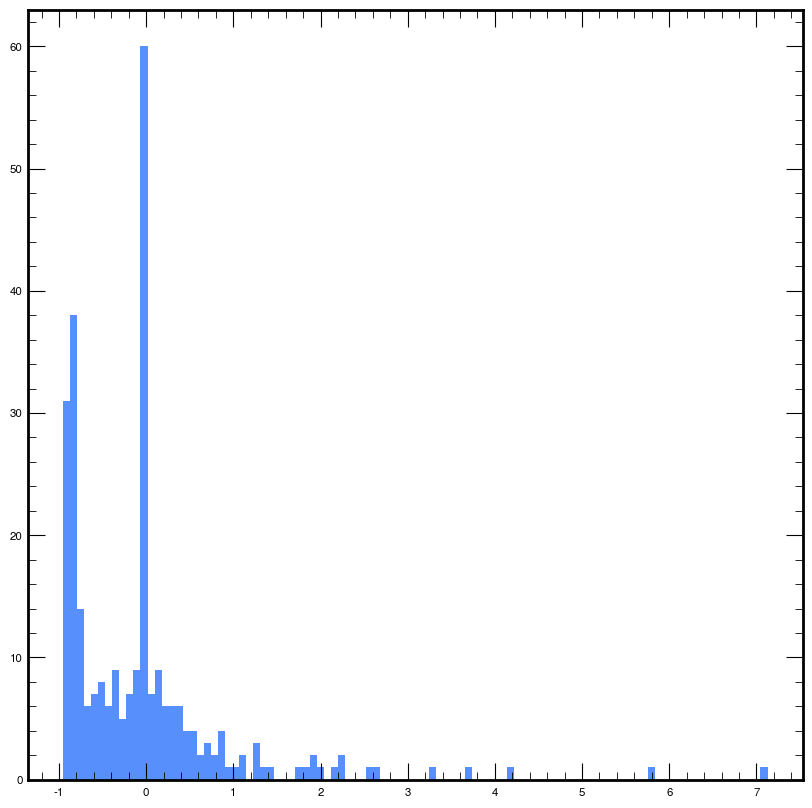

In [6]:
vals = (df.calibrated_E - df.reco_showers_E) / df.reco_showers_E
fig, ax = plt.subplots()
ax.hist(vals, bins=100)
fig.show()

In [7]:
cutoff = 1.0
print(len(df[vals > cutoff]))
df[vals>cutoff]

23


,reco_showers_E,pred_showers_E,calibrated_E,true_showers_E,number_batch
27,0.039210,0.127051,0.127051,1.093514,1026.0
2,0.019748,0.131651,0.133367,1.155459,1926.0
20,0.054800,0.126421,0.126421,1.230194,2764.0
56,0.036550,0.101189,0.101189,1.312037,3594.0
14,0.050963,0.106586,0.106586,1.223944,5022.0
25,0.033274,0.141718,0.141718,1.300115,6409.0
17,0.046299,0.150482,0.150482,1.318913,7182.0
32,0.049485,0.143075,0.143075,1.222463,7334.0
22,0.021300,0.078055,0.078055,1.040114,7981.0
179,0.020574,0.096899,0.096899,1.383728,11022.0


In [8]:
sd_hgb[(sd_hgb.number_batch == 9503) & ((sd_hgb.pid==2112) | (pd.isna(sd_hgb.pid)))].pred_showers_E.sum() / sd_hgb[(sd_hgb.number_batch == 9503) & ((sd_hgb.pid==2112) | (pd.isna(sd_hgb.pid)))].true_showers_E.sum()

0.66554254

In [9]:
sd_pandora[(sd_pandora.number_batch == 9503) & ((sd_pandora.pid==2112) | (pd.isna(sd_pandora.pid)))].pred_showers_E.sum() / sd_pandora[(sd_pandora.number_batch == 9503) & ((sd_pandora.pid==2112) | (pd.isna(sd_pandora.pid)))].true_showers_E.sum()

0.23416682

In [10]:
int(sd_pandora.number_batch.max()), int(sd_hgb.number_batch.max())

(29296, 29296)

In [7]:
evt = get_response_for_event_energy(
     sd_pandora, sd_hgb, perfect_pid=False, mass_zero=False, ML_pid=True
)

YOOOOOOOOOOOOOOOOOOOOOOOO


/afs/cern.ch/work/g/gkrzmanc/mlpf_2024/src/utils/inference/event_metrics.py:156: RuntimeWarning: invalid value encountered in divide
  pred_vect /= np.linalg.norm(pred_vect, axis=1).reshape(-1, 1)
/afs/cern.ch/work/g/gkrzmanc/mlpf_2024/src/utils/inference/event_metrics.py:157: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1772.)
  pred_vect[np.isnan(pred_vect)] = 0


Using Pandora provided PID for Pandora


/afs/cern.ch/work/g/gkrzmanc/mlpf_2024/src/utils/inference/event_metrics.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_E_jet = scatter_sum(torch.tensor(true_e), batch_idx)
/afs/cern.ch/work/g/gkrzmanc/mlpf_2024/src/utils/inference/event_metrics.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_E_jet = scatter_sum(torch.tensor(pred_E), batch_idx)


173525


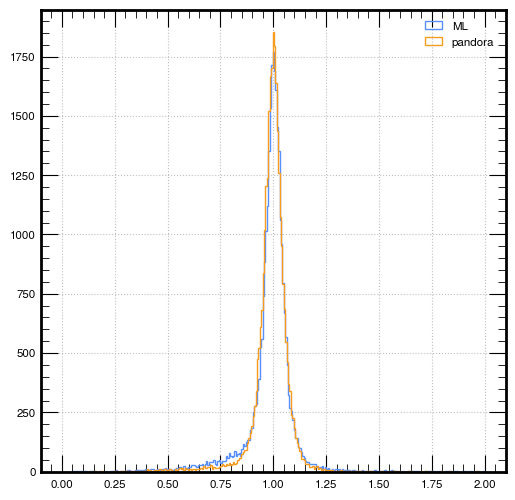

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
model = evt["mass_over_true_model"]
pand = evt["mass_over_true_pandora"]
ax.hist(model, bins=np.linspace(0, 2, 300), histtype="step", label='ML')
ax.hist(pand, bins=np.linspace(0, 2, 300), histtype='step', label='pandora')
ax.legend()
ax.grid()
fig.show()

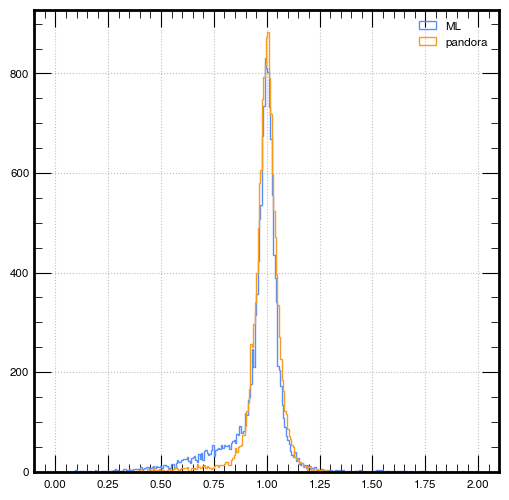

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
model = evt["mass_over_true_model"]
pand = evt["mass_over_true_pandora"]
ax.hist(model, bins=np.linspace(0, 2, 300), histtype="step", label='ML')
ax.hist(pand, bins=np.linspace(0, 2, 300), histtype='step', label='pandora')
ax.legend()
ax.grid()
fig.show()

In [12]:
len(model), len(pand)

(3300, 10100)

In [21]:
#model_filt = model[model<0.85]
#pand_filt = pand[pand<0.85]

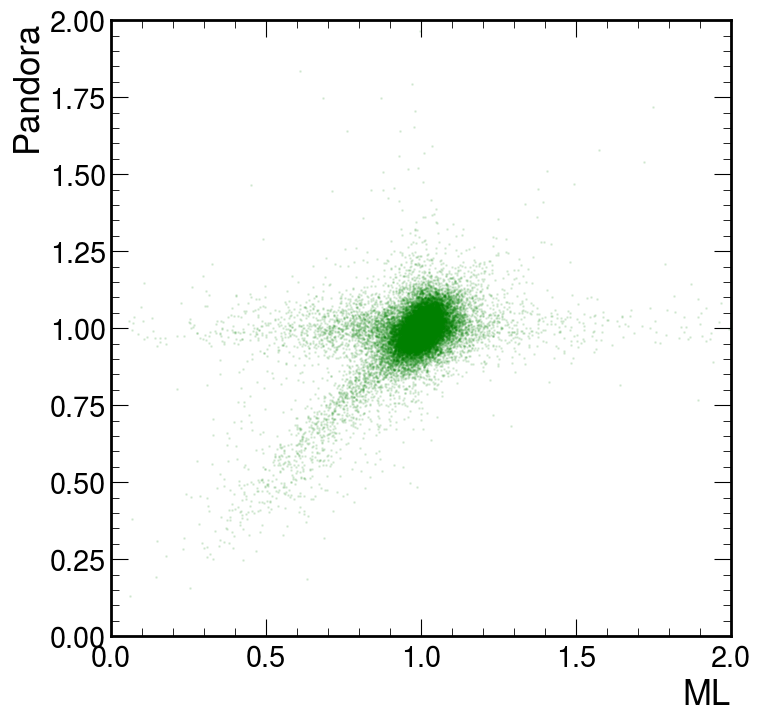

In [24]:
# Scatter plot of model and pand_filt
matplotlib.rcParams["font.size"] = 25
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(model, pand, s=1, alpha=0.1, color='green')
ax.set_xlim([0, 2])
ax.set_ylim([0, 2])
ax.set_xlabel("ML")
ax.set_ylabel("Pandora")
fig.show()

In [25]:
filt_idx = np.where((model < 0.6) * (np.abs(pand-1) < 0.1))[0]
filt_idx

array([  166,   290,   339,   474,   481,   504,   536,   585,  1108,
        1205,  1217,  1507,  1840,  2485,  2779,  2855,  3147,  3176,
        3179,  3232,  3260,  3329,  3417,  3681,  4030,  4287,  4688,
        4936,  4943,  4981,  5022,  5368,  5645,  5867,  5885,  6056,
        6096,  6124,  6237,  6441,  6463,  6485,  6490,  6650,  6693,
        6703,  6725,  6781,  6887,  6995,  7002,  7030,  7149,  7177,
        7393,  7477,  7531,  7548,  7828,  7920,  7928,  7959,  8033,
        8055,  8291,  8508,  8541,  8734,  8820,  9028,  9039,  9131,
        9174,  9183,  9203,  9436, 10056, 10165, 10168, 10259, 10419,
       10461, 10499, 10813, 10948, 11365, 11723, 12008, 12079, 12127,
       12634, 12735, 12826, 12845, 13052, 13141, 13374, 13445, 13758,
       13803, 14143, 14295, 14351, 14422, 14487, 14529, 14578, 14645,
       14683, 14816, 14907, 14970, 15138, 15147, 15254, 15364, 15376,
       15461, 15683, 15919, 16090, 16366, 16444, 16622, 16653, 16767,
       17042, 17110,

In [107]:
batch_idx = 481

In [14]:
def fake_energy_frac(df):
    is_pandora = "pandora_calibrated_pfo" in df.columns
    fakes=pd.isna(df.pid)
    if is_pandora:
        col = "pandora_calibrated_pfo"
    else:
        col = "calibrated_E"
    return df[fakes][col].sum() / df.true_showers_E.sum()

def missed_energy_frac(df):
    is_pandora = "pandora_calibrated_pfo" in df.columns
    missed = pd.isna(df.pred_showers_E) | (df.pred_showers_E == 0)
    if is_pandora:
        col = "pandora_calibrated_pfo"
    else:
        col = "calibrated_E"
    return df[missed].true_showers_E.sum() / df.true_showers_E.sum()
    

In [35]:
fake_energy_frac_distr = [fake_energy_frac(sd_hgb[sd_hgb.number_batch==i]) for i in filt_idx]
missed_energy_frac_distr = [missed_energy_frac(sd_hgb[sd_hgb.number_batch==i]) for i in filt_idx]
fake_energy_frac_distr_pandora = [fake_energy_frac(sd_pandora[sd_pandora.number_batch==i]) for i in filt_idx]
missed_energy_frac_distr_pandora = [missed_energy_frac(sd_pandora[sd_pandora.number_batch==i]) for i in filt_idx]


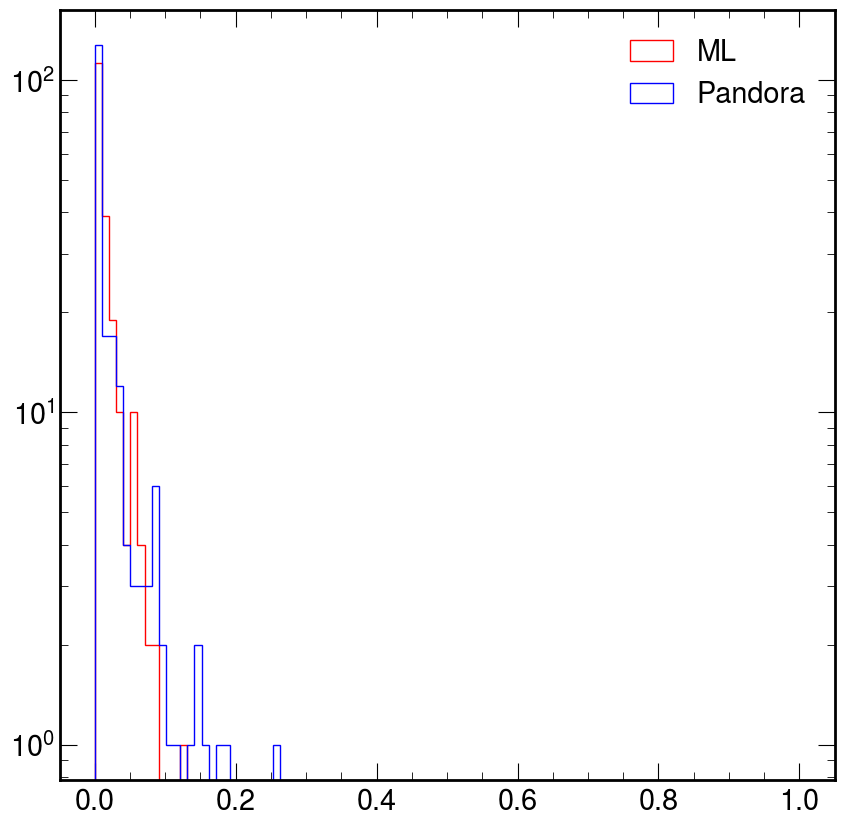

In [37]:
fig, ax = plt.subplots()
ax.hist(fake_energy_frac_distr, bins=np.linspace(0, 1, 100), histtype="step", label="ML", color="red")
ax.hist(fake_energy_frac_distr_pandora, bins=np.linspace(0, 1, 100), histtype="step", label="Pandora", color="blue")
ax.legend()
ax.set_yscale("log")
fig.show()


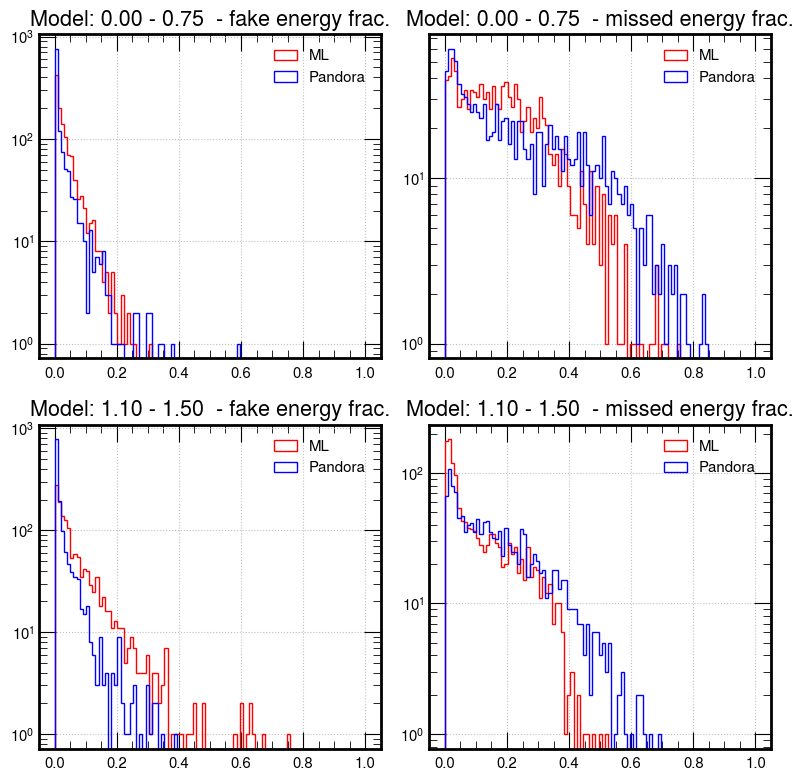

In [15]:
filt_regions = [[0, 0.75], [1.1, 1.5]]
matplotlib.rcParams["font.size"] = 13
fig, ax = plt.subplots(len(filt_regions), 2, figsize=(8, 4*(len(filt_regions))))

for i, item in enumerate(filt_regions):
    filt = np.where((model < item[1]) * (model > item[0]))[0]
    fake_energy_frac_distr = [fake_energy_frac(sd_hgb[sd_hgb.number_batch==q]) for q in filt]
    missed_energy_frac_distr = [missed_energy_frac(sd_hgb[sd_hgb.number_batch==q]) for q in filt]
    fake_energy_frac_distr_pandora = [fake_energy_frac(sd_pandora[sd_pandora.number_batch==q]) for q in filt]
    missed_energy_frac_distr_pandora = [missed_energy_frac(sd_pandora[sd_pandora.number_batch==q]) for q in filt]
    ax[i,0].hist(fake_energy_frac_distr, bins=np.linspace(0, 1, 100), histtype="step", label="ML", color="red")
    ax[i,0].hist(fake_energy_frac_distr_pandora, bins=np.linspace(0, 1, 100), histtype="step", label="Pandora", color="blue")
    ax[i,0].set_yscale("log")
    ax[i,0].legend()
    ax[i,0].grid()
    ax[i,1].hist(missed_energy_frac_distr, bins=np.linspace(0, 1, 100), histtype="step", label="ML", color="red")
    ax[i,1].hist(missed_energy_frac_distr_pandora, bins=np.linspace(0, 1, 100), histtype="step", label="Pandora", color="blue")
    ax[i,1].set_yscale("log")
    ax[i,1].legend()
    ax[i,1].grid()
    ax[i,0].set_title(f"Model in [{item[0]:.2f},{item[1]:.2f}] - fake energy frac.")
    ax[i,1].set_title(f"Model in [{item[0]:.2f},{item[1]:.2f}] - missed energy frac.")

fig.tight_layout()
fig.show()


In [112]:
sd_pandora[sd_pandora.number_batch == batch_idx][["true_showers_E", "pred_showers_E", "reco_showers_E", "pandora_calibrated_pfo", "pandora_pid", "pid", "is_track_in_cluster"]]

,true_showers_E,pred_showers_E,reco_showers_E,pandora_calibrated_pfo,pandora_pid,pid,is_track_in_cluster
0,18.192902,15.823670,16.709007,17.667919,2112.0,3122.0,0.0
1,7.313356,3.956367,6.342785,6.263962,11.0,-211.0,1.0
2,14.155547,11.873462,14.364971,13.790681,211.0,211.0,1.0
3,0.299527,NaN,0.000000,0.000000,NaN,211.0,0.0
4,0.291793,NaN,0.000000,0.000000,NaN,-211.0,0.0
5,0.446900,NaN,0.281436,0.000000,NaN,-211.0,0.0
6,1.276641,0.708762,0.737108,1.185233,211.0,321.0,1.0
7,25.060520,43.391300,28.642054,45.673576,2112.0,321.0,0.0
8,21.605186,NaN,18.178968,0.000000,NaN,-321.0,0.0
9,1.034265,1.119327,1.145518,1.139217,22.0,22.0,0.0


In [110]:

print("Model E", sd_hgb[sd_hgb.number_batch == batch_idx].calibrated_E.sum())
print("Pandora E", sd_pandora[sd_pandora.number_batch == batch_idx].pandora_calibrated_pfo.sum())
print("True E", sd_pandora[sd_pandora.number_batch == batch_idx].true_showers_E.sum())


Model E 50.11511
Pandora E 93.83238
True E 96.74945


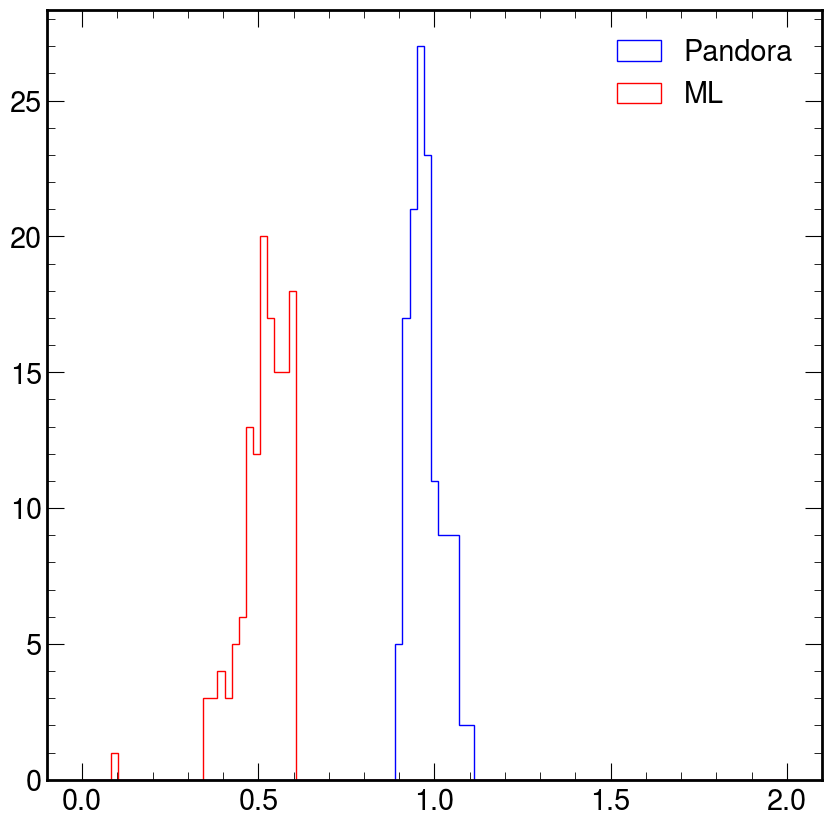

In [98]:
sd_filt = sd_hgb[sd_hgb.number_batch.isin(filt_idx)]
pandora_filt = sd_pandora[sd_pandora.number_batch.isin(filt_idx)]

from torch_scatter import scatter_sum
E_true = scatter_sum(torch.tensor(sd_filt.true_showers_E.values), torch.tensor(sd_filt.number_batch.values).long())
E_model = scatter_sum(torch.tensor(sd_filt.calibrated_E.values), torch.tensor(sd_filt.number_batch.values).long())
E_pandora = scatter_sum(torch.tensor(pandora_filt.pandora_calibrated_pfo.values), torch.tensor(pandora_filt.number_batch.values).long())

fig, ax = plt.subplots()
ax.hist(E_pandora/E_true, bins=np.linspace(0, 2, 100), histtype="step", label="Pandora", color="blue")
ax.hist(E_model/E_true, bins=np.linspace(0, 2, 100), histtype="step", label="ML", color="red")
ax.legend()
fig.show()


In [92]:
torch.tensor(sd_filt.number_batch.values).long().dtype

torch.int64